# Классификатор комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные, опираясь на набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества F1 не меньше 0.75. 

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импорт библиотек

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import random

from tqdm import tqdm

from itertools import chain

import spacy

import re


In [2]:
# Загрузка данных

df = pd.read_csv('/datasets/toxic_comments.csv')
df_tweets = df[['text', 'toxic']]
df_tweets.reset_index(drop=True, inplace=True)
display(df_tweets.sample(5))
display(df_tweets.info())

,text,toxic
30987,"""\n""""Families, couples and individuals are wel...",1
36350,HELP \n\nHEY BUDDY I DON'T LIKE AT ALL!!! \n\...,0
20578,"Oh come, on not again. Admins, stop wasting ...",1
93978,That sounds like a nice segue into a busing se...,0
25254,Yellow Evan block \n\nI'm sorry if I'm putting...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

In [3]:
# Проверка на пустые строки в исходных данных

print(df_tweets['text'].isnull().sum())
print(df_tweets['toxic'].isnull().sum())

0
0


In [4]:
# Проверка дубликатов

print(df_tweets[df_tweets['text'].duplicated()])

Empty DataFrame
Columns: [text, toxic]
Index: []


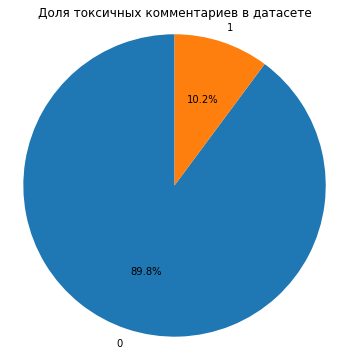

In [5]:
# Анализ долей токсичных и обычных комментариев

value_counts = df_tweets['toxic'].value_counts()

# Построение pie диаграммы классов

plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Доля токсичных комментариев в датасете')
plt.axis('equal') 
plt.show()

In [6]:
# Загрузка SpaCy English модели

nlp = spacy.load('en_core_web_sm')


# Функция очистки текста

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s'’]", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Функция лемматизации

def lemmatize_with_pos_spacy(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

# Обработка исходного текста батчами 

batch_size = 1000
num_batches = len(df_tweets) // batch_size + 1
for batch_num in tqdm(range(num_batches)):
    batch_start = batch_num * batch_size
    batch_end = (batch_num + 1) * batch_size
    batch_df = df_tweets.iloc[batch_start:batch_end]
    
    # Очистка и лемматизация

    batch_df['cleaned_text'] = batch_df['text'].apply(clean_text)
    batch_df['lemmatized_text'] = batch_df['cleaned_text'].apply(lemmatize_with_pos_spacy)
    
    # Вывод статуса

    print(f"Processed batch {batch_num + 1}/{num_batches}")
    
    # Объединение батчей в единый датафрейм

    if batch_num == 0:
        final_df = batch_df.copy()
    else:
        final_df = pd.concat([final_df, batch_df], ignore_index=True)

# Вывод финального датафрейма

print("\nFinal processed DataFrame:")
display(final_df.head());


  0%|          | 0/160 [00:00<?, ?it/s]/tmp/ipykernel_134/3395822895.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['cleaned_text'] = batch_df['text'].apply(clean_text)
/tmp/ipykernel_134/3395822895.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['lemmatized_text'] = batch_df['cleaned_text'].apply(lemmatize_with_pos_spacy)
  1%|          | 1/160 [00:14<37:52, 14.29s/it]

Processed batch 1/160


  1%|▏         | 2/160 [00:28<38:05, 14.47s/it]

Processed batch 2/160


  2%|▏         | 3/160 [00:57<54:44, 20.92s/it]

Processed batch 3/160


  2%|▎         | 4/160 [01:26<1:02:52, 24.18s/it]

Processed batch 4/160


  3%|▎         | 5/160 [01:55<1:06:30, 25.75s/it]

Processed batch 5/160


  4%|▍         | 6/160 [02:23<1:08:44, 26.78s/it]

Processed batch 6/160


  4%|▍         | 7/160 [02:51<1:09:13, 27.15s/it]

Processed batch 7/160


  5%|▌         | 8/160 [03:20<1:10:00, 27.64s/it]

Processed batch 8/160


  6%|▌         | 9/160 [03:47<1:09:18, 27.54s/it]

Processed batch 9/160


  6%|▋         | 10/160 [04:15<1:08:56, 27.58s/it]

Processed batch 10/160


  7%|▋         | 11/160 [04:43<1:09:02, 27.80s/it]

Processed batch 11/160


  8%|▊         | 12/160 [05:12<1:09:15, 28.07s/it]

Processed batch 12/160


  8%|▊         | 13/160 [05:39<1:07:50, 27.69s/it]

Processed batch 13/160


  9%|▉         | 14/160 [06:07<1:07:59, 27.94s/it]

Processed batch 14/160


  9%|▉         | 15/160 [06:35<1:07:20, 27.87s/it]

Processed batch 15/160


 10%|█         | 16/160 [07:02<1:06:15, 27.61s/it]

Processed batch 16/160


 11%|█         | 17/160 [07:30<1:06:15, 27.80s/it]

Processed batch 17/160


 11%|█▏        | 18/160 [07:51<1:00:47, 25.68s/it]

Processed batch 18/160


 12%|█▏        | 19/160 [08:04<51:32, 21.93s/it]  

Processed batch 19/160


 12%|█▎        | 20/160 [08:16<44:14, 18.96s/it]

Processed batch 20/160


 13%|█▎        | 21/160 [08:29<39:12, 16.93s/it]

Processed batch 21/160


 14%|█▍        | 22/160 [08:41<35:59, 15.65s/it]

Processed batch 22/160


 14%|█▍        | 23/160 [08:54<33:30, 14.68s/it]

Processed batch 23/160


 15%|█▌        | 24/160 [09:06<32:01, 14.13s/it]

Processed batch 24/160


 16%|█▌        | 25/160 [09:19<30:54, 13.74s/it]

Processed batch 25/160


 16%|█▋        | 26/160 [09:32<29:43, 13.31s/it]

Processed batch 26/160


 17%|█▋        | 27/160 [09:44<29:05, 13.12s/it]

Processed batch 27/160


 18%|█▊        | 28/160 [09:58<29:02, 13.20s/it]

Processed batch 28/160


 18%|█▊        | 29/160 [10:10<28:30, 13.06s/it]

Processed batch 29/160


 19%|█▉        | 30/160 [10:23<28:00, 12.92s/it]

Processed batch 30/160


 19%|█▉        | 31/160 [10:36<27:46, 12.92s/it]

Processed batch 31/160


 20%|██        | 32/160 [10:49<27:35, 12.93s/it]

Processed batch 32/160


 21%|██        | 33/160 [11:02<27:30, 13.00s/it]

Processed batch 33/160


 21%|██▏       | 34/160 [11:15<27:23, 13.04s/it]

Processed batch 34/160


 22%|██▏       | 35/160 [11:28<27:11, 13.05s/it]

Processed batch 35/160


 22%|██▎       | 36/160 [11:42<27:17, 13.20s/it]

Processed batch 36/160


 23%|██▎       | 37/160 [11:55<27:05, 13.22s/it]

Processed batch 37/160


 24%|██▍       | 38/160 [12:08<26:33, 13.06s/it]

Processed batch 38/160


 24%|██▍       | 39/160 [12:21<26:18, 13.05s/it]

Processed batch 39/160


 25%|██▌       | 40/160 [12:33<25:40, 12.84s/it]

Processed batch 40/160


 26%|██▌       | 41/160 [12:46<25:14, 12.73s/it]

Processed batch 41/160


 26%|██▋       | 42/160 [12:58<24:52, 12.65s/it]

Processed batch 42/160


 27%|██▋       | 43/160 [13:11<24:50, 12.74s/it]

Processed batch 43/160


 28%|██▊       | 44/160 [13:23<24:12, 12.52s/it]

Processed batch 44/160


 28%|██▊       | 45/160 [13:36<24:03, 12.55s/it]

Processed batch 45/160


 29%|██▉       | 46/160 [13:48<23:35, 12.42s/it]

Processed batch 46/160


 29%|██▉       | 47/160 [14:01<23:51, 12.67s/it]

Processed batch 47/160


 30%|███       | 48/160 [14:14<23:42, 12.70s/it]

Processed batch 48/160


 31%|███       | 49/160 [14:27<23:32, 12.73s/it]

Processed batch 49/160


 31%|███▏      | 50/160 [14:39<23:16, 12.70s/it]

Processed batch 50/160


 32%|███▏      | 51/160 [14:52<23:10, 12.76s/it]

Processed batch 51/160


 32%|███▎      | 52/160 [15:05<23:15, 12.93s/it]

Processed batch 52/160


 33%|███▎      | 53/160 [15:19<23:09, 12.99s/it]

Processed batch 53/160


 34%|███▍      | 54/160 [15:32<23:14, 13.16s/it]

Processed batch 54/160


 34%|███▍      | 55/160 [15:45<22:59, 13.13s/it]

Processed batch 55/160


 35%|███▌      | 56/160 [15:59<23:02, 13.30s/it]

Processed batch 56/160


 36%|███▌      | 57/160 [16:12<22:47, 13.28s/it]

Processed batch 57/160


 36%|███▋      | 58/160 [16:25<22:24, 13.18s/it]

Processed batch 58/160


 37%|███▋      | 59/160 [16:38<21:54, 13.01s/it]

Processed batch 59/160


 38%|███▊      | 60/160 [16:50<21:35, 12.96s/it]

Processed batch 60/160


 38%|███▊      | 61/160 [17:03<21:05, 12.79s/it]

Processed batch 61/160


 39%|███▉      | 62/160 [17:16<21:00, 12.86s/it]

Processed batch 62/160


 39%|███▉      | 63/160 [17:29<20:59, 12.98s/it]

Processed batch 63/160


 40%|████      | 64/160 [17:42<20:48, 13.00s/it]

Processed batch 64/160


 41%|████      | 65/160 [17:55<20:20, 12.85s/it]

Processed batch 65/160


 41%|████▏     | 66/160 [18:07<19:57, 12.74s/it]

Processed batch 66/160


 42%|████▏     | 67/160 [18:21<20:04, 12.95s/it]

Processed batch 67/160


 42%|████▎     | 68/160 [18:33<19:27, 12.69s/it]

Processed batch 68/160


 43%|████▎     | 69/160 [18:45<19:08, 12.62s/it]

Processed batch 69/160


 44%|████▍     | 70/160 [18:58<18:57, 12.64s/it]

Processed batch 70/160


 44%|████▍     | 71/160 [19:11<18:51, 12.71s/it]

Processed batch 71/160


 45%|████▌     | 72/160 [19:23<18:36, 12.69s/it]

Processed batch 72/160


 46%|████▌     | 73/160 [19:36<18:28, 12.74s/it]

Processed batch 73/160


 46%|████▋     | 74/160 [19:49<18:14, 12.73s/it]

Processed batch 74/160


 47%|████▋     | 75/160 [20:03<18:24, 12.99s/it]

Processed batch 75/160


 48%|████▊     | 76/160 [20:16<18:29, 13.21s/it]

Processed batch 76/160


 48%|████▊     | 77/160 [20:30<18:18, 13.24s/it]

Processed batch 77/160


 49%|████▉     | 78/160 [20:43<18:18, 13.39s/it]

Processed batch 78/160


 49%|████▉     | 79/160 [20:56<17:42, 13.11s/it]

Processed batch 79/160


 50%|█████     | 80/160 [21:09<17:30, 13.13s/it]

Processed batch 80/160


 51%|█████     | 81/160 [21:21<16:55, 12.86s/it]

Processed batch 81/160


 51%|█████▏    | 82/160 [21:34<16:45, 12.88s/it]

Processed batch 82/160


 52%|█████▏    | 83/160 [21:47<16:31, 12.88s/it]

Processed batch 83/160


 52%|█████▎    | 84/160 [22:00<16:15, 12.83s/it]

Processed batch 84/160


 53%|█████▎    | 85/160 [22:12<15:56, 12.76s/it]

Processed batch 85/160


 54%|█████▍    | 86/160 [22:25<15:40, 12.72s/it]

Processed batch 86/160


 54%|█████▍    | 87/160 [22:38<15:29, 12.74s/it]

Processed batch 87/160


 55%|█████▌    | 88/160 [22:50<15:04, 12.56s/it]

Processed batch 88/160


 56%|█████▌    | 89/160 [23:03<14:57, 12.64s/it]

Processed batch 89/160


 56%|█████▋    | 90/160 [23:15<14:31, 12.45s/it]

Processed batch 90/160


 57%|█████▋    | 91/160 [23:28<14:36, 12.70s/it]

Processed batch 91/160


 57%|█████▊    | 92/160 [23:41<14:34, 12.86s/it]

Processed batch 92/160


 58%|█████▊    | 93/160 [23:54<14:15, 12.77s/it]

Processed batch 93/160


 59%|█████▉    | 94/160 [24:07<14:04, 12.79s/it]

Processed batch 94/160


 59%|█████▉    | 95/160 [24:20<13:57, 12.89s/it]

Processed batch 95/160


 60%|██████    | 96/160 [24:32<13:41, 12.84s/it]

Processed batch 96/160


 61%|██████    | 97/160 [24:45<13:28, 12.83s/it]

Processed batch 97/160


 61%|██████▏   | 98/160 [24:58<13:10, 12.75s/it]

Processed batch 98/160


 62%|██████▏   | 99/160 [25:10<12:53, 12.68s/it]

Processed batch 99/160


 62%|██████▎   | 100/160 [25:23<12:42, 12.71s/it]

Processed batch 100/160


 63%|██████▎   | 101/160 [25:36<12:36, 12.82s/it]

Processed batch 101/160


 64%|██████▍   | 102/160 [25:50<12:35, 13.03s/it]

Processed batch 102/160


 64%|██████▍   | 103/160 [26:03<12:23, 13.04s/it]

Processed batch 103/160


 65%|██████▌   | 104/160 [26:16<12:09, 13.03s/it]

Processed batch 104/160


 66%|██████▌   | 105/160 [26:29<11:56, 13.03s/it]

Processed batch 105/160


 66%|██████▋   | 106/160 [26:42<11:40, 12.97s/it]

Processed batch 106/160


 67%|██████▋   | 107/160 [26:55<11:30, 13.03s/it]

Processed batch 107/160


 68%|██████▊   | 108/160 [27:07<11:09, 12.87s/it]

Processed batch 108/160


 68%|██████▊   | 109/160 [27:20<10:57, 12.90s/it]

Processed batch 109/160


 69%|██████▉   | 110/160 [27:33<10:49, 13.00s/it]

Processed batch 110/160


 69%|██████▉   | 111/160 [27:46<10:36, 12.98s/it]

Processed batch 111/160


 70%|███████   | 112/160 [27:59<10:12, 12.76s/it]

Processed batch 112/160


 71%|███████   | 113/160 [28:11<09:52, 12.62s/it]

Processed batch 113/160


 71%|███████▏  | 114/160 [28:24<09:42, 12.66s/it]

Processed batch 114/160


 72%|███████▏  | 115/160 [28:36<09:23, 12.53s/it]

Processed batch 115/160


 72%|███████▎  | 116/160 [28:49<09:13, 12.59s/it]

Processed batch 116/160


 73%|███████▎  | 117/160 [29:01<08:58, 12.52s/it]

Processed batch 117/160


 74%|███████▍  | 118/160 [29:14<08:46, 12.53s/it]

Processed batch 118/160


 74%|███████▍  | 119/160 [29:26<08:36, 12.59s/it]

Processed batch 119/160


 75%|███████▌  | 120/160 [29:38<08:18, 12.47s/it]

Processed batch 120/160


 76%|███████▌  | 121/160 [29:51<08:06, 12.47s/it]

Processed batch 121/160


 76%|███████▋  | 122/160 [30:04<08:00, 12.64s/it]

Processed batch 122/160


 77%|███████▋  | 123/160 [30:16<07:44, 12.57s/it]

Processed batch 123/160


 78%|███████▊  | 124/160 [30:29<07:31, 12.53s/it]

Processed batch 124/160


 78%|███████▊  | 125/160 [30:41<07:18, 12.53s/it]

Processed batch 125/160


 79%|███████▉  | 126/160 [30:54<07:06, 12.55s/it]

Processed batch 126/160


 79%|███████▉  | 127/160 [31:08<07:04, 12.87s/it]

Processed batch 127/160


 80%|████████  | 128/160 [31:20<06:49, 12.80s/it]

Processed batch 128/160


 81%|████████  | 129/160 [31:33<06:33, 12.68s/it]

Processed batch 129/160


 81%|████████▏ | 130/160 [31:45<06:22, 12.74s/it]

Processed batch 130/160


 82%|████████▏ | 131/160 [31:58<06:05, 12.59s/it]

Processed batch 131/160


 82%|████████▎ | 132/160 [32:10<05:51, 12.57s/it]

Processed batch 132/160


 83%|████████▎ | 133/160 [32:23<05:37, 12.51s/it]

Processed batch 133/160


 84%|████████▍ | 134/160 [32:35<05:24, 12.46s/it]

Processed batch 134/160


 84%|████████▍ | 135/160 [32:48<05:14, 12.56s/it]

Processed batch 135/160


 85%|████████▌ | 136/160 [33:00<04:59, 12.49s/it]

Processed batch 136/160


 86%|████████▌ | 137/160 [33:13<04:51, 12.66s/it]

Processed batch 137/160


 86%|████████▋ | 138/160 [33:26<04:41, 12.80s/it]

Processed batch 138/160


 87%|████████▋ | 139/160 [33:39<04:29, 12.81s/it]

Processed batch 139/160


 88%|████████▊ | 140/160 [33:51<04:11, 12.58s/it]

Processed batch 140/160


 88%|████████▊ | 141/160 [34:04<03:58, 12.56s/it]

Processed batch 141/160


 89%|████████▉ | 142/160 [34:16<03:44, 12.46s/it]

Processed batch 142/160


 89%|████████▉ | 143/160 [34:29<03:34, 12.64s/it]

Processed batch 143/160


 90%|█████████ | 144/160 [34:42<03:22, 12.68s/it]

Processed batch 144/160


 91%|█████████ | 145/160 [34:54<03:10, 12.69s/it]

Processed batch 145/160


 91%|█████████▏| 146/160 [35:07<02:56, 12.58s/it]

Processed batch 146/160


 92%|█████████▏| 147/160 [35:19<02:41, 12.41s/it]

Processed batch 147/160


 92%|█████████▎| 148/160 [35:32<02:30, 12.57s/it]

Processed batch 148/160


 93%|█████████▎| 149/160 [35:45<02:19, 12.72s/it]

Processed batch 149/160


 94%|█████████▍| 150/160 [35:58<02:07, 12.74s/it]

Processed batch 150/160


 94%|█████████▍| 151/160 [36:10<01:54, 12.77s/it]

Processed batch 151/160


 95%|█████████▌| 152/160 [36:23<01:41, 12.71s/it]

Processed batch 152/160


 96%|█████████▌| 153/160 [36:36<01:29, 12.75s/it]

Processed batch 153/160


 96%|█████████▋| 154/160 [36:48<01:15, 12.65s/it]

Processed batch 154/160


 97%|█████████▋| 155/160 [37:00<01:02, 12.50s/it]

Processed batch 155/160


 98%|█████████▊| 156/160 [37:13<00:50, 12.64s/it]

Processed batch 156/160


 98%|█████████▊| 157/160 [37:26<00:37, 12.62s/it]

Processed batch 157/160


 99%|█████████▉| 158/160 [37:38<00:25, 12.59s/it]

Processed batch 158/160


 99%|█████████▉| 159/160 [37:51<00:12, 12.69s/it]

Processed batch 159/160


100%|██████████| 160/160 [37:55<00:00, 14.22s/it]

Processed batch 160/160

Final processed DataFrame:


,text,toxic,cleaned_text,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...,daww he match this background colour I m seemi...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...,hey man I m really not try to edit war its jus...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impro...,more I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [7]:
# Для удобства создадим отдельные переменные для входных и целевого параметров
X = final_df['lemmatized_text']
y = final_df['toxic']


In [8]:
# Разделение данных на тренировочную и тестовую выборки
# важно использовать stratify параметр из-за преобладания одного из типов комментариев

X_learn, X_test, y_learn, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_learn, y_learn, test_size=0.1, random_state=42, stratify = y_learn)

In [9]:
# Преобразование текстовых данных с помощью TF-IDF

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words = stopwords)
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_val_vect = tfidf_vectorizer.transform(X_val)
X_test_vect = tfidf_vectorizer.transform(X_test)

feature_names = tfidf_vectorizer.get_feature_names()

# Вывод имен признаков

print("Примеры отдельных признаков:")
print(random.sample(feature_names, 20))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Примеры отдельных признаков:
['absolutely', 'marcolfuck', 'communist', 'polite', 'restatement', 'performance', 'unreliable', 'professional', 'soap', 'australian', 'military', 'wine', 'fbi', 'notability', 'alone', 'sentiment', 'punishment', 'tend', 'cover', 'abuse']


### Выводы

Загружены и проанализированы данные, проведен поиск пропусков и дубликатов. 
Исследовано соотношение типов комментариев, созданы тестовые и тренировочные наборы данных. 
Проведена векторизация текста с использованием TF-IDF.

## Обучение

### LogisticRegression model

In [10]:
# Инициализация LogisticRegression 

classifier = LogisticRegression(max_iter=10000, C=10, random_state=42) 

# Обучение

classifier.fit(X_train_vect, y_train)

# Предсказание

y_train_pred = classifier.predict(X_train_vect)
y_val_pred = classifier.predict(X_val_vect)

# Расчет F1 score для тренировочного и валидационного набора данных

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Train F1-score LogisticRegression: {train_f1}")
print(f"Val F1-score LogisticRegression: {val_f1}")

Train F1-score LogisticRegression: 0.812433918375978
Val F1-score LogisticRegression: 0.7700534759358288


### CatBoostClassifier model

In [11]:
# Инициализация CatBoostClassifier

cat_classifier = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    depth=6, 
    l2_leaf_reg=10, 
    verbose=100,
    random_state = 42
)

# Обучение

cat_classifier.fit(X_train_vect, y_train)

# Предсказание

y_train_pred = cat_classifier.predict(X_train_vect)
y_val_pred = cat_classifier.predict(X_val_vect)

# Расчет F1 score для тренировочного и валидационного набора данных

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Train F1-score CatBoostClassifier: {train_f1}")
print(f"Val F1-score CatBoostClassifier: {val_f1}")

0:	learn: 0.5926359	total: 1.96s	remaining: 32m 37s
100:	learn: 0.1660385	total: 2m 14s	remaining: 20m 1s
200:	learn: 0.1454112	total: 4m 21s	remaining: 17m 19s
300:	learn: 0.1338678	total: 6m 26s	remaining: 14m 57s
400:	learn: 0.1260997	total: 8m 31s	remaining: 12m 43s
500:	learn: 0.1205954	total: 10m 34s	remaining: 10m 32s
600:	learn: 0.1162443	total: 12m 39s	remaining: 8m 24s
700:	learn: 0.1128917	total: 14m 42s	remaining: 6m 16s
800:	learn: 0.1110489	total: 16m 43s	remaining: 4m 9s
900:	learn: 0.1096299	total: 18m 43s	remaining: 2m 3s
999:	learn: 0.1082586	total: 20m 43s	remaining: 0us
Train F1-score CatBoostClassifier: 0.8005774025633174
Val F1-score CatBoostClassifier: 0.7584025306445235


### DummyClassifier model

In [12]:
# DummyClassifier инициализация

dummy_clf = DummyClassifier(strategy = 'stratified')

# Обучение

dummy_clf.fit(X_train_vect, y_train)

# Предсказание

y_val_pred = dummy_clf.predict(X_val_vect)
y_train_pred = dummy_clf.predict(X_train_vect)


# Расчет F1 score для тренировочного и валидационного набора данных

train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Train F1-score DummyClassifier: {train_f1}")
print(f"Val F1-score DummyClassifier: {val_f1}")

Train F1-score DummyClassifier: 0.10296743797256734
Val F1-score DummyClassifier: 0.11547659719849676


### Промежуточные выводы

Были обучены 2 модели классификаторов: LogisticRegression и CatBoostClassifier. Модели продемонстрировали схожие значения метрики f1-score на тренировочных и валидационных выборках: LogisticRegression 0.77/0.74 и CatBoostClassifier 0.8/0.76, соответственно. DummyClassifier продемонстрировал 0.10/0.11. CatBoostClassifier f1-score превзошел требуемый порог 0.75 на валидационной выборке.

### Оценка выбранной модели

In [13]:
# Предсказание CatBoostClassifier для тестового набора данных

y_test_pred = cat_classifier.predict(X_test_vect)

# Расчет F1-score CatBoostClassifier для тестового набора данных

test_f1 = f1_score(y_test, y_test_pred)

print(f"Test F1-score CatBoostClassifier: {test_f1}")

Test F1-score CatBoostClassifier: 0.7614321162708259


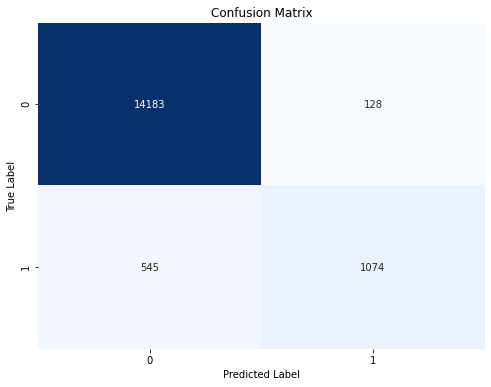

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     14311
           1       0.89      0.66      0.76      1619

    accuracy                           0.96     15930
   macro avg       0.93      0.83      0.87     15930
weighted avg       0.96      0.96      0.95     15930



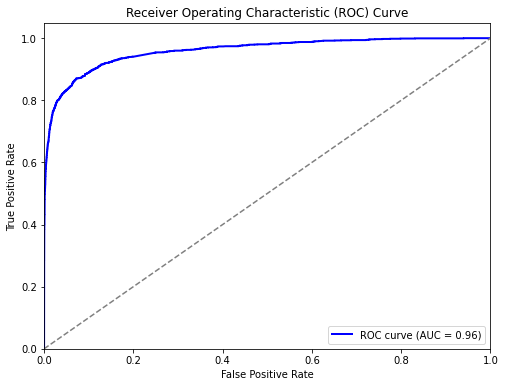

In [14]:
# Оценка выбранной CatBoostClassifier модели 

y_pred = y_test_pred

# Сформируем отчет и confusion matrix CatBoostClassifier модели на тестовой выборке

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Построим confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Вывод отчета

print('Classification Report:\n', class_report)

# Построим ROC curve

y_probs = cat_classifier.predict_proba(X_test_vect)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Выводы
Выбранная модель CatBoostClassifier продемонстрировала F1-score 0.76 на тестовой выборке, что лучше, чем пороговое значение 0.75. Также были построены confusion matrix, classification report и ROC curve для этой модели. 

## Выводы

Были загружен и изучен датасет с комментариями с разметкой токсичности как целевой признак. 

Данные подверглись очистке, лемматизации и векторизации с использованием TF-IDF.

Были обучены 2 модели классификаторов (LogisticRegression и CatBoostClassifier), последняя удовлетворила требуемому порогу f1-score 0.75, продемонстрировав 0.76 на валидационной выборке. 

На тестовой выборке выбранная модель CatBoostClassifier также продемонстрировала f1-score 0.76, что лучше порогового значения 0.75.

Обученная модель сможет лечь в основу инструмента для поиску и модерации комментариев для интернет-магазина Викишоп. 
